In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot

In [196]:
def sample_from_disjoint_interval(size):
    coin_flip = np.random.rand(size) < 0.5
    left = np.random.uniform(-1.5, -0.5, size)
    right = np.random.uniform(0.5, 1.5, size)
    return np.where(coin_flip, left, right)

def generate_connection_matrix(p, s):
    #s is the probability of a connection, if you 
    #want the sparsity to be the same as in the paper 
    #set s=1/(p-1)

    # Generate binary adjacency matrix (lower triangle only)
    rand_matrix = np.random.binomial(1, s, size=(p, p))
    lower_triangle_mask = np.tril(np.ones((p, p)), k=-1)
    adj_matrix = rand_matrix * lower_triangle_mask

    # Count how many 1s (non-zero connections) to sample that many weights
    num_connections = int(np.sum(adj_matrix))

    # Generate random weights from the disjoint interval
    weights = sample_from_disjoint_interval(num_connections)

    # Fill the weights into the matrix (vectorized)
    connection_matrix = np.zeros((p, p))
    connection_matrix[adj_matrix == 1] = weights

    return connection_matrix

def sample_uniform_noise(n, p, variances):
    # Uniform distribution on [-sqrt(3 * var), sqrt(3 * var)] has variance = var
    e = np.zeros((n, p))
    for i in range(p):
        scale = np.sqrt(3 * variances[i])
        e[:, i] = np.random.uniform(low=-scale, high=scale, size=n)
    return e



import numpy as np

def generate_dataset(E, B, permutation=None):
    """
    Generate dataset X from external influences E and connection matrix B,
    with Gaussian shift and optional column permutation.
    
    Parameters:
    - E: (n, p) matrix of external influences
    - B: (p, p) connection strength matrix
    - permutation: list or array of length p (optional). If None, a random permutation is generated.
    
    Returns:
    - X_perm: the permuted data matrix (n, p)
    - means: Gaussian shifts applied to each variable (p,)
    - permutation: the permutation used (to apply consistently across groups)
    """
    n, p = E.shape
    I = np.eye(p)
    A_inv = np.linalg.inv(I - B).T
    X = E @ A_inv  # Step: X = E (I - B)^-1

    # Step: Add Gaussian mean shift (N(0, 4) → std = 2)
    means = np.random.normal(loc=0, scale=2.0, size=p)
    X += means  # Broadcast to shift each variable

    # Step: Apply consistent variable permutation
    if permutation is None:
        permutation = np.random.permutation(p)

    X_perm = X[:, permutation]  # Permute columns
    
    return X_perm, means, permutation





In [197]:
p=5
s=0.5
n=10000
B=generate_connection_matrix(p, s)

In [198]:
B

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-1.01544738,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.50055843, -0.58787966,  0.        ,  0.        ,  0.        ],
       [ 1.18449243, -1.49077568,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [199]:
variances = np.random.uniform(low=1,high=3,size=p)

In [200]:
E = sample_uniform_noise(n, 5, variances)

In [201]:
X, m, perm_ = generate_dataset(E, B, permutation=None)

In [203]:
m

array([ 0.492608  , -0.4916362 , -0.05906891,  1.63714322,  2.03941558])

In [204]:
perm_

array([4, 2, 0, 1, 3])

## Estimating back

In [123]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot

In [205]:
#now we can retrieve the causal graph given the generated dataset.
model = lingam.DirectLiNGAM()
model.fit(X)

In [217]:
inverse_perm = np.argsort(perm_)
B_est_original_order = model.adjacency_matrix_[inverse_perm, :][:, inverse_perm]

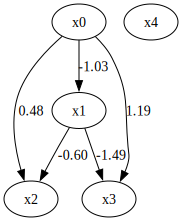

In [218]:
make_dot(B_est_original_order)

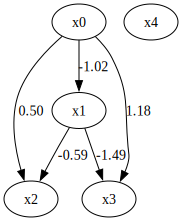

In [208]:
make_dot(B)

In [209]:
B

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-1.01544738,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.50055843, -0.58787966,  0.        ,  0.        ,  0.        ],
       [ 1.18449243, -1.49077568,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [176]:
pd.DataFrame(np.linalg.inv(np.eye(B.shape[0])-B))

,0,1,2,3,4
0,1.000000,0.000000,0.000000e+00,0.0,0.0
1,-1.189383,1.000000,0.000000e+00,0.0,0.0
2,1.555515,-1.307834,1.000000e+00,0.0,0.0
3,0.000000,0.000000,0.000000e+00,1.0,0.0
4,-1.116829,1.451669,-4.011083e-17,-0.0,1.0


In [180]:
E @ np.linalg.inv(np.eye(B.shape[0])-B)

array([[ 0.09250627, -1.32752091,  1.3171883 , -0.59839534,  0.0093852 ],
       [ 6.71503071, -5.55637378,  0.62600746, -0.01051429, -2.0399647 ],
       [-0.91717156,  2.8824024 , -1.13635301, -0.30808711, -0.01489659],
       ...,
       [ 2.30641582, -2.7243032 ,  0.93700595, -1.59570493, -0.63990743],
       [ 1.55921053, -0.69237   ,  0.66840825, -0.51068507, -0.60600935],
       [ 4.53482231, -5.31469328,  1.27988385, -0.82425475, -1.17490355]])

In [190]:
E @ np.linalg.inv(np.eye(B.shape[0])-B)

array([[ 0.09250627, -1.32752091,  1.3171883 , -0.59839534,  0.0093852 ],
       [ 6.71503071, -5.55637378,  0.62600746, -0.01051429, -2.0399647 ],
       [-0.91717156,  2.8824024 , -1.13635301, -0.30808711, -0.01489659],
       ...,
       [ 2.30641582, -2.7243032 ,  0.93700595, -1.59570493, -0.63990743],
       [ 1.55921053, -0.69237   ,  0.66840825, -0.51068507, -0.60600935],
       [ 4.53482231, -5.31469328,  1.27988385, -0.82425475, -1.17490355]])

In [183]:
pd.DataFrame(np.linalg.inv(np.eye(B.shape[0])-B).T)

,0,1,2,3,4
0,1.0,-1.189383,1.555515,0.0,-1.116829e+00
1,0.0,1.000000,-1.307834,0.0,1.451669e+00
2,0.0,0.000000,1.000000,0.0,-4.011083e-17
3,0.0,0.000000,0.000000,1.0,-0.000000e+00
4,0.0,0.000000,0.000000,0.0,1.000000e+00


In [185]:
E[0] @ np.linalg.inv(np.eye(B.shape[0])-B).T

array([-1.4921477 ,  2.15625351, -1.50283234, -0.59839534,  2.22969715])

In [187]:
pd.DataFrame(np.linalg.inv(np.eye(B.shape[0])-B))

,0,1,2,3,4
0,1.000000,0.000000,0.000000e+00,0.0,0.0
1,-1.189383,1.000000,0.000000e+00,0.0,0.0
2,1.555515,-1.307834,1.000000e+00,0.0,0.0
3,0.000000,0.000000,0.000000e+00,1.0,0.0
4,-1.116829,1.451669,-4.011083e-17,-0.0,1.0


In [186]:
E[0] @ np.linalg.inv(np.eye(B.shape[0])-B)

array([ 0.09250627, -1.32752091,  1.3171883 , -0.59839534,  0.0093852 ])

In [188]:
B

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-1.18938332,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -1.30783353,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.60976163,  1.45166899,  0.        ,  0.        ,  0.        ]])

In [ ]:
X[:[0,1,2,3,4]]

array([[-1.55173556,  0.54384132, -3.45907759, -2.2563203 ,  2.88862831],
       [ 1.29067674, -4.99470112,  3.09323309, -1.66843925, -5.46765796],
       [ 2.46060531, -3.19202117, -1.02673267, -1.96601207, -0.11231771],
       ...,
       [-0.60322183, -1.53574463, -1.1195077 , -3.25362989, -0.20116749],
       [ 1.0456506 , -1.86544267, -0.95691526, -2.16861003,  0.35953731],
       [-1.12956201, -2.27504997,  0.19025852, -2.4821797 , -2.1303323 ]])

In [195]:
X[:,[0,1,2,4,3]]

array([[-1.55173556,  0.54384132, -3.45907759,  2.88862831, -2.2563203 ],
       [ 1.29067674, -4.99470112,  3.09323309, -5.46765796, -1.66843925],
       [ 2.46060531, -3.19202117, -1.02673267, -0.11231771, -1.96601207],
       ...,
       [-0.60322183, -1.53574463, -1.1195077 , -0.20116749, -3.25362989],
       [ 1.0456506 , -1.86544267, -0.95691526,  0.35953731, -2.16861003],
       [-1.12956201, -2.27504997,  0.19025852, -2.1303323 , -2.4821797 ]])